In [1]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt

# Templates to load in
template_nii = "../smartspim/SmartSPIM-template_2024-05-16_11-26-14/smartspim_lca_template_25.nii.gz"
annotation_nii = "../smartspim/SmartSPIM-template_2024-05-16_11-26-14/ccf_annotation_to_template_moved_25.nii.gz"
smartspim_template = nib.load(template_nii)
annotation_nii = nib.load(annotation_nii)

Load and process the different channels of Eric's lightsheet brain and save it into a different nii file

In [2]:
# Path to the directory containing the TIFF files
tiff_dir = "../Eric_bloodvessel_lightsheet_data/25um downsampled tiff/"
# Where to save the NIfTI files
output_nii_path_C0 = "../Eric_bloodvessel_lightsheet_data/processed/eric_25um_C0.nii"
output_nii_path_C1 = "../Eric_bloodvessel_lightsheet_data/processed/eric_25um_C1.nii"


# Load all TIFF files in the directory
tiff_files = sorted([f for f in os.listdir(tiff_dir) if f.endswith('.tif')])

# Initialize a list to hold image slices
image_slices_C0 = []
image_slices_C1 = []


# Loop through the TIFF files and load each as a numpy array
for tiff_file in tiff_files:
    img_path = os.path.join(tiff_dir, tiff_file)
    img = Image.open(img_path)
    img_array = np.array(img)
    if 'C0' in tiff_file:
        image_slices_C0.append(img_array)
    else:
        image_slices_C1.append(img_array)


# Stack the slices into a 3D numpy array (Assuming slices are 2D images)
image_3d_C0 = np.stack(image_slices_C0, axis=-1)[:, :, 2:]
image_3d_C1 = np.stack(image_slices_C1, axis=-1)[:, :, 2:]


# Convert the numpy array to a NIfTI image
nii_img_C0 = nib.Nifti1Image(image_3d_C0, np.eye(4))
nii_img_C1 = nib.Nifti1Image(image_3d_C1, np.eye(4))


# Save the NIfTI file
nib.save(nii_img_C0, output_nii_path_C0)
nib.save(nii_img_C1, output_nii_path_C1)

print(f"Saved NIfTI file to {output_nii_path_C0}")
print(f"Saved NIfTI file to {output_nii_path_C1}")

Saved NIfTI file to ../Eric_bloodvessel_lightsheet_data/eric_25um_C0.nii
Saved NIfTI file to ../Eric_bloodvessel_lightsheet_data/eric_25um_C1.nii


Process and crop/clip the indices of the average and annotation template to remove black space.

In [4]:
# Load the template images into memory and define where to save the cropped images
smartspim_template = nib.load(template_nii).get_fdata()
annotation_template = annotation_nii.get_fdata()
output_nii_path_annotation = "../Eric_bloodvessel_lightsheet_data/processed/smartspim_annotation_cropped.nii"
output_nii_path_smartspim = "../Eric_bloodvessel_lightsheet_data/processed/smartspim_25um_cropped.nii"

#plt.imshow(smartspim_template[:, :, 69])
#plt.show()

#plt.imshow(smartspim_template[:, :, 393])
#plt.show()

# Rotate the templates to match Eric's orientation
placeholder = smartspim_template.copy()
rotated_smartspim_template = np.rot90(placeholder, k=1, axes=(0, 1))
placeholder = annotation_template.copy()
rotated_annotation_template = np.rot90(placeholder, k=1, axes=(0, 1))

#plt.imshow(smartspim_template[:, :, 200])
#plt.show()

#plt.imshow(rotated_smartspim_template[:, :, 200])
#plt.show()

# Crop the average template to get rid of black space
smartspim_cropped = rotated_smartspim_template[:, :, 70:393]
nii_img_spim = nib.Nifti1Image(smartspim_cropped, np.eye(4))
nib.save(nii_img_spim, output_nii_path_smartspim)

# Crop the annotation template
annotation_cropped = rotated_annotation_template[:, :, 70:393]
nii_img_annotation = nib.Nifti1Image(annotation_cropped, np.eye(4))
nib.save(nii_img_annotation, output_nii_path_annotation)

# Brighten the average template as an alternative version
smartspim_brightened = smartspim_cropped.copy() * 1000
nii_img_spim_brightened = nib.Nifti1Image(smartspim_brightened, np.eye(4))
nib.save(nii_img_spim_brightened, output_nii_path_smartspim.replace('.nii', '_brightened.nii'))

(648, 576, 323)


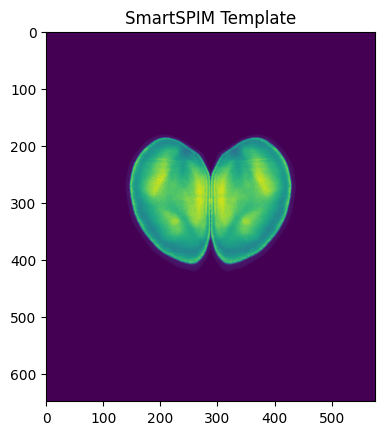

(589, 571, 96)


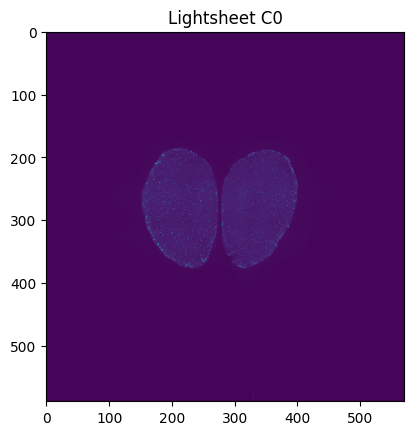

In [15]:
print(smartspim_cropped.shape)
plt.imshow(smartspim_brightened[:, :, 30])
plt.title("SmartSPIM Template")
plt.show()

print(image_3d_C0.shape)
plt.imshow(image_3d_C0[:, :, 5])
plt.title("Lightsheet C0")
plt.show()

In [80]:
print(np.max(smartspim_cropped))
print(np.average(smartspim_cropped))
print(np.median(smartspim_cropped))

print()
print(np.max(smartspim_brightened))
print(np.average(smartspim_brightened))
print(np.median(smartspim_brightened))

print()
print(np.max(image_3d_C0))
print(np.average(image_3d_C0))
print(np.median(image_3d_C0))

1.877767562866211
0.2087316792690582
0.0
1877.767562866211
208.73167926905808
0.0

11087
275.87926291085745
129.0


allen_ccf = "CCF_DATA/average_template_25.nii.gz"
allen = nib.load(allen_ccf).get_fdata()
allen2 = np.swapaxes(allen, 1, 2)
allen2 = np.rot90(allen2, k=2, axes=(0, 1))
allen2_nii = nib.Nifti1Image(allen2, np.eye(4))
nib.save(allen2_nii, "../Eric_bloodvessel_lightsheet_data/processed/allen_axial_25.nii")
plt.imshow(allen2[:, :, 80])

Register lightsheet with Ants

import ants
template_path = "../Eric_bloodvessel_lightsheet_data/smartspim_25um_cropped.nii"
input_path = "../Eric_bloodvessel_lightsheet_data/eric_25um_C0.nii"
fixed_image = ants.image_read(template_path)
moving_image = ants.image_read(input_path)
result = ants.registration(fixed_image, moving_image, type_of_transform = 'SyN' )

(648, 576, 323)


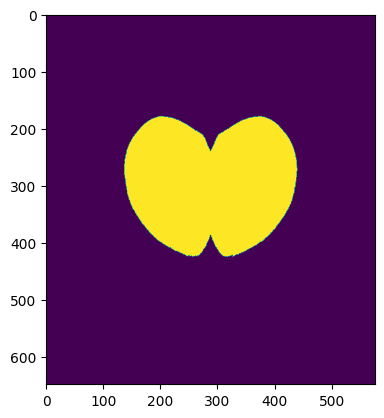

In [10]:
# Compute averaged threshold border
smartspim_binary = np.where(smartspim_cropped > 0, 1, 0)
plt.imshow(smartspim_binary[:, :, 30])
print(smartspim_binary.shape)

In [17]:
import imageio
result = "../Eric_bloodvessel_lightsheet_data/output/result.nii"
result = nib.load(result).get_fdata()
print("Result dimensions", result.shape)

result2 = "../Eric_bloodvessel_lightsheet_data/output/result_brightened.nii"
result2 = nib.load(result2).get_fdata()
print("Result (brightened) dimensions", result2.shape)

# Directory to save frames
frames_dir = "../Eric_bloodvessel_lightsheet_data/frames"
os.makedirs(frames_dir, exist_ok=True)

for i in range(result2.shape[2]):
    plt.imshow(result2[:, :, i])
    plt.contour(smartspim_binary[:, :, i], colors='r')
    plt.title(f"Result slice {i}")
    plt.axis('off')
    #plt.show()
    # Save the frame
    frame_path = os.path.join(frames_dir, f"frame_{i:03d}.png")
    plt.savefig(frame_path)
    plt.close()
    

# Create GIF from saved frames
gif_path = "../Eric_bloodvessel_lightsheet_data/output/result_animation.gif"
with imageio.get_writer(gif_path, mode='I', duration=0.1) as writer:
    for i in range(result2.shape[2]):
        frame_path = os.path.join(frames_dir, f"frame_{i:03d}.png")
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"GIF saved to {gif_path}")

Result dimensions (648, 576, 323)
Result (brightened) dimensions (648, 576, 323)


C:\Users\Andy\AppData\Local\Temp\ipykernel_41012\3259461322.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


GIF saved to ../Eric_bloodvessel_lightsheet_data/result_animation.gif
